In [141]:
from os.path import join
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from sklearn.neighbors import NearestNeighbors
from sklearn.mixture import GaussianMixture
from sklearn.cluster import MeanShift, DBSCAN, estimate_bandwidth

## Import Pre-Proccessed Data:

In [142]:
data = pd.read_csv("dataset_final.csv")


In [143]:
data.columns

Index(['ID', 'Age', 'UseByTime', 'AthleticsActivities', 'WaterActivities',
       'FitnessActivities', 'TeamActivities', 'RacketActivities',
       'CombatActivities', 'SpecialActivities', 'OtherActivities', 'Dropout',
       'Contract_Duration', 'PercentageOfVisits', 'PercentageOfClasses',
       'Freq_Visits_Day', 'Freq_Classes_Contract', 'Visits_ActivePeriod',
       'Gender_Female'],
      dtype='object')

We now need to separate the different types of features we have:

In [144]:
metric_features = ['Age','Contract_Duration', 'PercentageOfVisits', 'PercentageOfClasses',
       'Freq_Visits_Day', 'Freq_Classes_Contract', 'Visits_ActivePeriod']

non_metric_features = data.columns.drop(metric_features).to_list()

In [145]:
activities = ['AthleticsActivities', 'WaterActivities','FitnessActivities','TeamActivities','RacketActivities','CombatActivities','SpecialActivities','OtherActivities']

In [146]:
attendance_perspective = ['Age', 'Contract_Duration', 'PercentageOfVisits', 'PercentageOfClasses',
       'Freq_Visits_Day', 'Visits_ActivePeriod']
#attendance_perspective = ['Age', 'Contract_Duration', 'PercentageOfVisits',
       #'Freq_Visits_Day', 'Visits_ActivePeriod']
compare = ['UseByTime','Dropout', 'Gender_Female', 'Age']
df_activities = data[activities].copy()
df_attendance = data[attendance_perspective].copy()
df_compare = data[compare].copy()

## Removing Outliers with DBSCAN:

In [147]:
from collections import Counter

from sklearn.cluster import DBSCAN

In [148]:
dbscan = DBSCAN(eps=2.25, min_samples = 2 * len(metric_features), n_jobs = -1)
dbscan_labels = dbscan.fit_predict(data[metric_features])

data = pd.concat([data, pd.Series(dbscan_labels, name = 'dbscan_labels', index = data.index)], axis =1)

Counter(dbscan_labels)

Counter({0: 14644, -1: 129})

In [149]:
data_dbscan_out = data[dbscan_labels == -1]
data = data[dbscan_labels != -1]

In [150]:
data.shape

(14644, 20)

In [151]:
df_attendance = data[attendance_perspective].copy()

## Density Based Clustering

In [152]:
def get_ss(df):
    """Computes the sum of squares for all variables given a dataset
    """
    ss = np.sum(df.var() * (df.count() - 1))
    return ss  # return sum of sum of squares of each df variable

### Mean Shift Clustering:

This algorithm is robust to outliers but has poor scalabily.

We can estimate the bandwith parameter directly using the **estimate_bandwith** function from *sklearn.cluster*

In [153]:
bandwidth = estimate_bandwidth(df_attendance, quantile=0.2, random_state=1, n_jobs=-1)
bandwidth

2.1133492834386796

In [154]:
ms = MeanShift(bandwidth=bandwidth, bin_seeding=True, n_jobs=4)
ms_labels = ms.fit_predict(df_attendance)

ms_n_clusters = len(np.unique(ms_labels))
print("Number of estimated clusters : %d" % ms_n_clusters)

Number of estimated clusters : 2


In [155]:
Counter(ms_labels)

Counter({0: 11284, 1: 3360})

This model does no give good results for our data. - Classes are having too much impact.

In [156]:
df_concat = pd.concat([df_attendance, pd.Series(ms_labels, index=data.index, name="ms_labels")], axis=1)
df_concat.head()

,Age,Contract_Duration,PercentageOfVisits,PercentageOfClasses,Freq_Visits_Day,Visits_ActivePeriod,ms_labels
0,3.083333,-0.490868,1.15,1.866571,0.763419,-0.201465,0
1,0.500000,0.285388,-0.20,0.104392,-0.204771,-0.501832,0
2,0.000000,-0.554795,0.50,0.000000,1.208748,0.619048,0
3,-1.166667,-0.257991,0.35,0.239981,0.463221,-0.300366,0
4,1.000000,1.152968,-0.50,0.000000,-0.255467,-0.600733,0


In [157]:
# Computing the R^2 of the cluster solution
sst = get_ss(df_attendance)  # get total sum of squares
ssw_labels = df_concat.groupby(by='ms_labels').apply(get_ss)  # compute ssw for each cluster labels
ssb = sst - np.sum(ssw_labels)  # remember: SST = SSW + SSB
r2 = ssb / sst
print("Cluster solution with R^2 of %0.4f" % r2)

Cluster solution with R^2 of 0.1931


## DBSCAN:

In [158]:
dbscan = DBSCAN(eps = 0.5, min_samples = len(attendance_perspective)*3)
dbscan_labels = dbscan.fit_predict(df_attendance)


dbscan_n_clusters = len(np.unique(dbscan_labels))
print("Number of estimated clusters : %d" % dbscan_n_clusters)

Counter(dbscan_labels)

Number of estimated clusters : 5


Counter({0: 8388, -1: 4582, 1: 1625, 2: 31, 3: 18})

In [159]:
# Computing the R^2 of the cluster solution
sst = get_ss(df_attendance)  # get total sum of squares
ssw_labels = df_concat.groupby(by='ms_labels').apply(get_ss)  # compute ssw for each cluster labels
ssb = sst - np.sum(ssw_labels)  # remember: SST = SSW + SSB
r2 = ssb / sst
print("Cluster solution with R^2 of %0.4f" % r2)

Cluster solution with R^2 of 0.1931


Also not good. Only detects noise.

## GMM

In [160]:
gmm = GaussianMixture(n_components=4, covariance_type='full', n_init=10, init_params='kmeans', random_state=1)
gmm_labels = gmm.fit_predict(df_attendance)
labels_proba = gmm.predict_proba(df_attendance)
gmm_labels

array([3, 3, 2, ..., 0, 2, 3])

In [161]:
gmm.weights_

array([0.35182808, 0.16099366, 0.26914654, 0.21803171])

In [162]:
gmm.covariances_.shape

(4, 6, 6)

In [163]:
Counter(gmm_labels)

Counter({0: 5104, 2: 3832, 3: 3192, 1: 2516})

In [164]:
df_concat = pd.concat([df_attendance, pd.Series(gmm_labels, index=data.index, name="gmm_labels")], axis=1)
df_concat.head()

,Age,Contract_Duration,PercentageOfVisits,PercentageOfClasses,Freq_Visits_Day,Visits_ActivePeriod,gmm_labels
0,3.083333,-0.490868,1.15,1.866571,0.763419,-0.201465,3
1,0.500000,0.285388,-0.20,0.104392,-0.204771,-0.501832,3
2,0.000000,-0.554795,0.50,0.000000,1.208748,0.619048,2
3,-1.166667,-0.257991,0.35,0.239981,0.463221,-0.300366,3
4,1.000000,1.152968,-0.50,0.000000,-0.255467,-0.600733,1


In [165]:
sst = get_ss(df_attendance)  # get total sum of squares
ssw_labels = df_concat.groupby(by='gmm_labels').apply(get_ss)  # compute ssw for each cluster labels
ssb = sst - np.sum(ssw_labels)  # remember: SST = SSW + SSB
r2 = ssb / sst
print("Cluster solution with R^2 of %0.4f" % r2)

Cluster solution with R^2 of 0.2279


------

In [166]:
def cluster_profiles(df, label_columns, figsize, compar_titles=None):
    """
    Pass df with labels columns of one or multiple clustering labels. 
    Then specify this label columns to perform the cluster profile according to them.
    """
    if compar_titles == None:
        compar_titles = [""]*len(label_columns)
        
    sns.set()
    fig, axes = plt.subplots(nrows=len(label_columns), ncols=2, figsize=figsize, squeeze=False)
    for ax, label, titl in zip(axes, label_columns, compar_titles):
        drop_cols = [i for i in label_columns if i!=label]
        dfax = df.drop(drop_cols, axis=1)
        
        
        centroids = dfax.groupby(by=label, as_index=False).mean()
        counts = dfax.groupby(by=label, as_index=False).count().iloc[:,[0,1]]
        counts.columns = [label, "counts"]
        
       
        pd.plotting.parallel_coordinates(centroids, label, color=sns.color_palette(), ax=ax[0])
        sns.barplot(x=label, y="counts", data=counts, ax=ax[1])

        
        handles, _ = ax[0].get_legend_handles_labels()
        cluster_labels = ["Cluster {}".format(i) for i in range(len(handles))]
        ax[0].annotate(text=titl, xy=(0.95,1.1), xycoords='axes fraction', fontsize=13, fontweight = 'heavy') 
        ax[0].legend(handles, cluster_labels) 
        ax[0].axhline(color="black", linestyle="--")
        ax[0].set_title("Cluster Means - {} Clusters".format(len(handles)), fontsize=13)
        ax[0].set_xticklabels(ax[0].get_xticklabels(), rotation=-20)
        ax[1].set_xticklabels(cluster_labels)
        ax[1].set_xlabel("")
        ax[1].set_ylabel("Absolute Frequency")
        ax[1].set_title("Cluster Sizes - {} Clusters".format(len(handles)), fontsize=13)
    
    plt.subplots_adjust(hspace=0.4, top=0.90)
    plt.suptitle("Cluster Simple Profilling", fontsize=23)
    plt.show()

/var/folders/x6/c7bgz3zn0hg_kdmljrfw7k_m0000gn/T/ipykernel_3265/2606922159.py:32: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[1].set_xticklabels(cluster_labels)


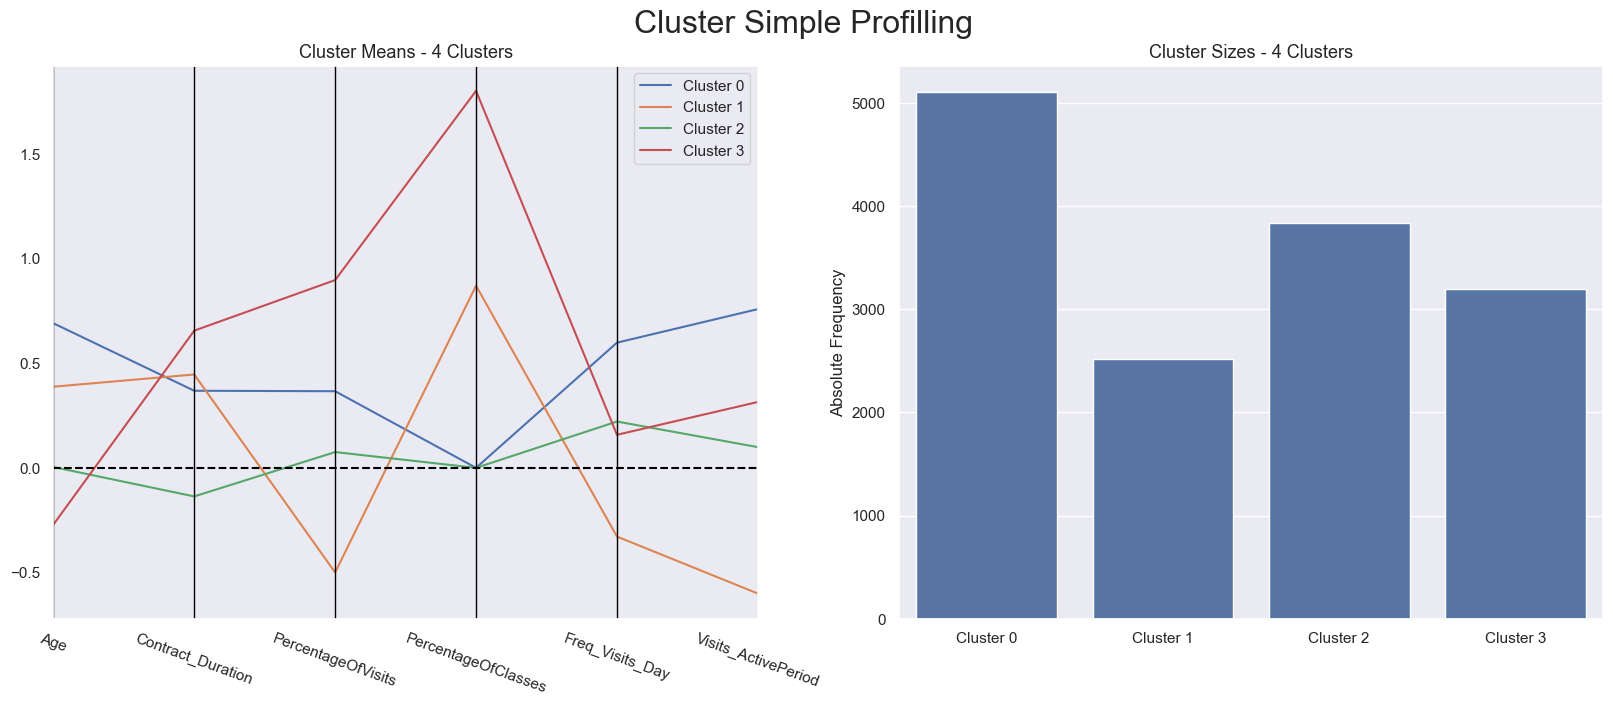

In [167]:
cluster_profiles(df_concat, ['gmm_labels'], (20,7))

- do we calculate r2 with all with attendance
- add more studies for profiling

I get best scores if i take out variables related with classes.
- We should remove at leat one of them as they are hihgly correlated and are affecting results:

Results are still fine with all but not as balanced.